## 데이터 구하기

In [1]:
import requests
import os

url = "https://query1.finance.yahoo.com/v7/finance/download/NQ=F?period1=969235200&period2=1603152000&interval=1d&events=history&includeAdjustedClose=true"
response = requests.get(url)
csv_file = 'data/csv/Nasdaq.csv'

with open(csv_file, "w") as fp:  
    fp.write(response.text)

In [2]:
import pandas as pd
df = pd.read_csv(csv_file)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0
2,2000-09-20,3801.5,3874.0,3715.5,3853.0,3853.0,78832.0
3,2000-09-21,3852.0,3874.0,3744.0,3765.0,3765.0,70719.0
4,2000-09-22,3673.0,3780.0,3615.0,3776.0,3776.0,55926.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

1072개가 되는 결측치가 있는 것을 확인했습니다. dropna 함수를 이용해 결측치를 제거합니다. 

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6166
삭제 후 데이터 길이(일자수): 5094


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

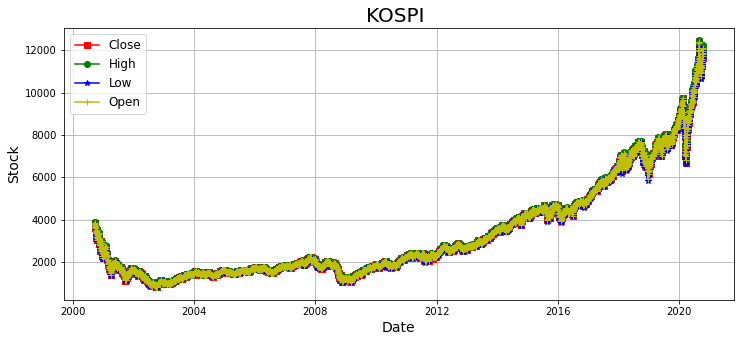

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')
plt.grid(True)
plt.show()

그래프로 시각화한 결과 눈에 띄는 이상치는 발견되지 않았습니다. 너무 색이 겹쳐보여서 4개의 그래프를 따로 보기 어려워 보입니다. 각기 어떤 관계를 가지고 있는 지 알기 위해 확대해 보겠습니다.  

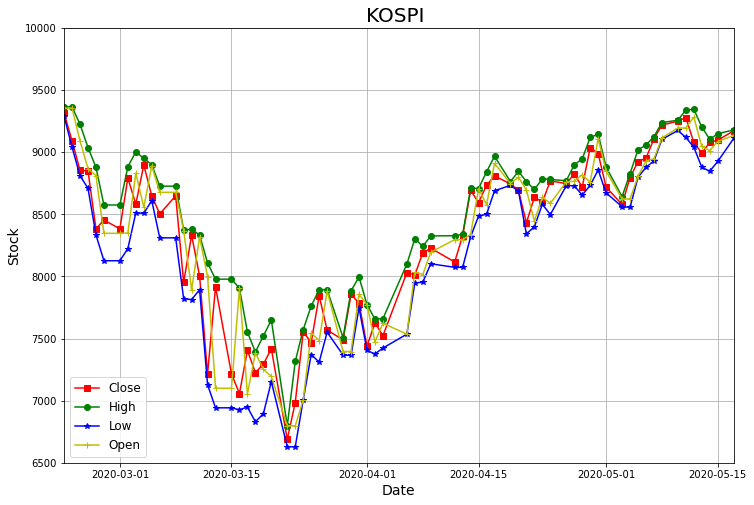

In [6]:
plt.rcParams["figure.figsize"] = (12,8)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')
plt.grid(True)
plt.ylim(6500, 10000)
plt.xlim(df.Date[4900], df.Date[4970])
plt.show()

앞선 그래프 보다 4개의 특성들의 관계를 확인 하는데 좋은 것 같습니다. 

## 기본 통계분석으로 이상치 찾기

In [7]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

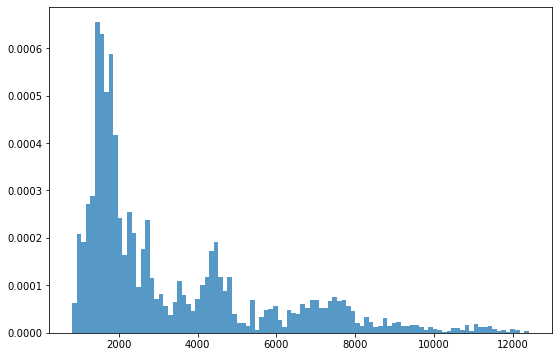

In [8]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

위의 그래프는 주식의 종가의 데이터 분포를 시각화한 모습입니다. 한눈에 봐도 정규분포와는 멀어보이지만, z-test로 확실한 비교를 해보겠습니다. 

In [9]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


역시 기본 raw 데이터는 정규분포로 나오기는 힘든 것 같습니다. 정규분포에 가까운 데이터를 추출하기 위해서 Time series decomposition 방법을 사용하겠습니다. 

### Time series decompose

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정

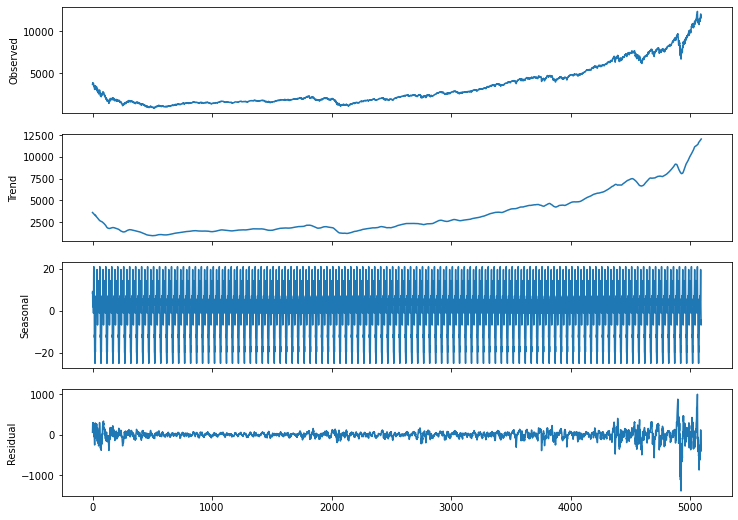

In [11]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

이렇게 Time series decompose를 하는 이유는 Trend와 Seasonal을 뽑아내고 남은 resid가 큰날은 뭔가 일반적인 흐름에서 벗어난 날로 해석될 수 있기 때문입니다.

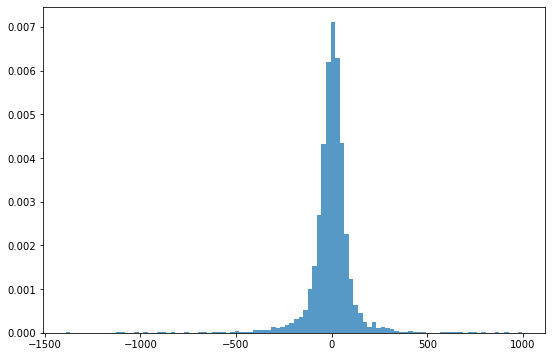

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [13]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8942734929026334 0.37117557875830953


residual의 분포를 그려보고 z-test를 통해 숫자를 확인해보니 p-value가 0.05 이상으로 아주 강하게 나타남을 확인 할 수 있었습니다. 

### 3σ 기준 신뢰구간으로 이상치 찾기

In [16]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 5-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+5*std)|(result.resid<mu-5*std)]))

평균: -1.3857940518773666 표준편차: 110.60068205120827
이상치 갯수: 36


적절한 이상치의 개수를 조절하기 위해 5-sigma를 기준으로 판단하였습니다. 

In [18]:
df.Date[result.resid[
    (result.resid>mu+5*std)|(result.resid<mu-5*std)].index]

4699   2019-06-03
4892   2020-02-12
4893   2020-02-13
4894   2020-02-14
4895   2020-02-16
4896   2020-02-18
4897   2020-02-19
4898   2020-02-20
4899   2020-02-21
4900   2020-02-23
4916   2020-03-12
4918   2020-03-15
4919   2020-03-16
4920   2020-03-17
4921   2020-03-18
4922   2020-03-19
4923   2020-03-20
4924   2020-03-22
4925   2020-03-23
4927   2020-03-25
4930   2020-03-29
4933   2020-04-01
4935   2020-04-03
5055   2020-08-26
5056   2020-08-27
5057   2020-08-28
5058   2020-08-30
5059   2020-08-31
5060   2020-09-01
5061   2020-09-02
5073   2020-09-21
5075   2020-09-23
5076   2020-09-24
5077   2020-09-25
5082   2020-10-02
5084   2020-10-06
Name: Date, dtype: datetime64[ns]

5094개의 데이터 샘플 중에서 36개는 이상치라는 사실을 확인했습니다. 그럼 탐지해낸 Anomalies는 Outlier인지, Novelties인지 구분해야 합니다. 4699번의 데이터를 제외하고 2020년에 이상치가 몰려있습니다. 날짜를 확인해보니 2-3월 코로나로 인해 주식시장이 급격하게 하락한날로 보입니다. 하지만 이러한 날은 Outlier라고 볼 수 없습니다. 어떠한 오류로 인해 손상된 데이터가 아닌 실제 존재하는 데이터이기 때문입니다.  
유의미한 데이터라고 생각하기 때문에 제거하지않고 그대로 둡니다. 

##  Unsupervised Clustering 으로 이상치 찾기

### 데이터 전처리

In [18]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,3324.303285,3355.663089,3292.204015,3326.157530,287799.978783
std,2390.871506,2412.479986,2369.858940,2394.718369,109505.690572
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.251875,1597.572500,1571.058750,1584.191100,220550.460000
50%,2263.775000,2291.211250,2231.463750,2264.287900,268829.760000
75%,4433.603750,4464.010625,4399.788125,4434.981250,319616.697500
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [19]:
sdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-0.008616,-0.006603,-0.011572,-0.009202,22.308320
std,11.597437,10.750511,12.297973,11.536247,14561.201046
min,-25.636086,-26.520436,-28.644252,-25.083118,-35924.068405
25%,-6.213432,-6.863078,-9.306915,-6.951926,-11595.348216
50%,2.283903,2.699136,2.467976,2.210146,-532.406293
75%,6.669267,6.280691,8.062987,6.577663,10207.830804
max,22.521422,20.130833,20.358573,20.989196,34516.285602


In [20]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-1.494218,-1.447168,-1.394948,-1.402187,151.569395
std,113.106458,102.570229,117.278403,110.763008,110728.081183
min,-1280.163546,-1494.231533,-1226.595518,-1389.770659,-602995.916675
25%,-37.912202,-35.100432,-38.323649,-37.371552,-53378.364320
50%,3.575670,3.350366,4.153527,2.958782,-550.641229
75%,40.353926,37.613888,42.048756,40.813609,51586.933556
max,996.821566,933.584382,941.409836,996.232816,810709.568301


In [21]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.49421837  -1.44716848  -1.39494753  -1.40218679 151.56939522]


array([[ 0.94173218,  0.84218124,  0.81160865,  0.59799575,  0.08320961],
       [ 0.48655464,  1.27770882,  1.3787828 ,  2.08212326,  0.10452718],
       [ 1.89305329,  2.00817542,  2.03390849,  2.72037058, -0.08886831],
       ...,
       [-0.65531897, -1.82608069, -0.96473553, -1.32833825,  0.28432658],
       [-1.31334711, -1.62375976, -0.70348768, -2.17905108, -0.36418376],
       [-2.12456827, -2.48917183, -2.57191425, -3.70655626,  0.57687603]])

### k-means 로 이상치 탐색하기

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1040',
 'group:1-count:74',
 'group:2-count:742',
 'group:3-count:106',
 'group:4-count:311',
 'group:5-count:397',
 'group:6-count:1046',
 'group:7-count:31',
 'group:8-count:20',
 'group:9-count:262',
 'group:10-count:438',
 'group:11-count:13',
 'group:12-count:35',
 'group:13-count:97',
 'group:14-count:482']

4,5 그룹의 경우 count가 20 이하로 분류된 특이한 그룹입니다. 어떤 날들이 이상치로 분류되었는지 확인해보고 왜 그렇게 분류되었는지 알아보겠습니다.

#### 어떤 날들이 분류된 걸까?

In [23]:
df[(kmeans.labels_==4)]

,Date,Open,High,Low,Close,Adj Close,Volume
435,2002-06-12,1102.000000,1124.50,1079.000000,1121.000000,1121.000000,320871.0
445,2002-06-26,1028.000000,1039.50,974.000000,1029.500000,1029.500000,300972.0
456,2002-07-11,966.500000,1004.50,948.500000,998.500000,998.500000,358951.0
463,2002-07-22,960.500000,985.50,931.000000,943.500000,943.500000,321536.0
465,2002-07-24,899.500000,953.00,873.000000,952.000000,952.000000,376117.0
...,...,...,...,...,...,...,...
4882,2020-01-31,9226.500000,9248.75,8966.000000,8997.750000,8997.750000,898384.0
5002,2020-06-24,10183.000000,10242.00,9927.250000,10010.799805,10010.799805,661645.0
5026,2020-07-23,10850.000000,10938.50,10514.500000,10548.200195,10548.200195,644189.0
5040,2020-08-09,11140.250000,11156.50,11073.000000,11105.250000,11105.250000,675946.0


In [24]:
df[(kmeans.labels_==5)]

,Date,Open,High,Low,Close,Adj Close,Volume
57,2000-12-07,2741.500000,2778.500000,2630.000000,2669.000000,2669.000000,14181.0
119,2001-03-09,1964.500000,1964.500000,1804.500000,1811.000000,1811.000000,6123.0
120,2001-03-12,1817.500000,1825.000000,1676.000000,1691.000000,1691.000000,5361.0
121,2001-03-13,1714.000000,1792.500000,1676.500000,1783.000000,1783.000000,6791.0
122,2001-03-14,1792.500000,1807.000000,1699.500000,1752.500000,1752.500000,5325.0
...,...,...,...,...,...,...,...
5041,2020-08-10,11140.200195,11156.500000,10928.200195,11072.000000,11072.000000,485730.0
5044,2020-08-13,11115.500000,11266.000000,11094.200195,11175.200195,11175.200195,413661.0
5045,2020-08-14,11180.500000,11237.799805,11096.000000,11133.799805,11133.799805,398616.0
5046,2020-08-16,11145.000000,11161.500000,11142.250000,11157.000000,11157.000000,245379.0


In [25]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,3322.800450,3354.209317,3290.797495,3324.746141,3324.746141,2.879739e+05
std,2390.480458,2411.646052,2370.093040,2394.337534,2394.337534,1.594162e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1592.812500,1608.312500,1576.500000,1593.000000,1593.000000,1.906860e+05
50%,2229.625000,2257.375000,2210.750000,2230.250000,2230.250000,2.656720e+05
75%,4445.000000,4464.687500,4417.875000,4448.250000,4448.250000,3.558778e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [26]:
df.iloc[4895:4905]

,Date,Open,High,Low,Close,Adj Close,Volume
4895,2020-02-16,9635.00,9668.75,9634.25,9663.75,9663.75,297278.0
4896,2020-02-18,9635.00,9687.50,9534.25,9636.00,9636.00,668505.0
4897,2020-02-19,9643.25,9748.75,9641.25,9733.50,9733.50,419130.0
4898,2020-02-20,9744.75,9763.00,9517.00,9624.25,9624.25,802424.0
4899,2020-02-21,9617.25,9623.75,9411.50,9458.00,9458.00,911839.0
4900,2020-02-23,9355.25,9365.00,9289.00,9315.00,9315.00,995989.0
4901,2020-02-24,9355.25,9365.00,9041.25,9091.00,9091.00,1171879.0
4902,2020-02-25,9091.00,9224.25,8810.00,8854.25,8854.25,1344897.0
4903,2020-02-26,8868.25,9037.50,8709.50,8850.25,8850.25,1251412.0
4904,2020-02-27,8811.50,8878.50,8334.25,8382.75,8382.75,1580041.0


#### 각 그룹은 어떤 특징을 가지고 있을까?

In [27]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.208734,0.210396,0.265769,0.249790,-0.406729
1,-1.553192,-1.667173,-2.103025,-2.062452,2.750833
2,0.352775,0.382333,0.291303,0.306922,0.506777
3,2.293611,2.380824,2.415479,2.376406,-0.438564
4,-0.186571,-0.213582,-0.418386,-0.402497,1.528749
5,-0.413290,-0.462715,-0.328959,-0.369733,-0.960155
6,-0.191460,-0.191263,-0.182387,-0.178142,0.219125
7,-4.262138,-4.603683,-4.243449,-4.319169,0.501229
8,6.027197,6.084572,6.079186,6.001044,-0.221431
9,0.259411,0.254501,0.316326,0.305125,-1.922633


4번 그룹의 경우 Open, High, Low, Close의 값이 유독 낮은 그룹이고,  
5번 그룹의 경우 Open, High, Low, Close의 값이 유독 높은 그룹입니다.  
두 그룹이 서로 상충됨을 알 수 있습니다.

####  왜 이상치로 분류된걸까?

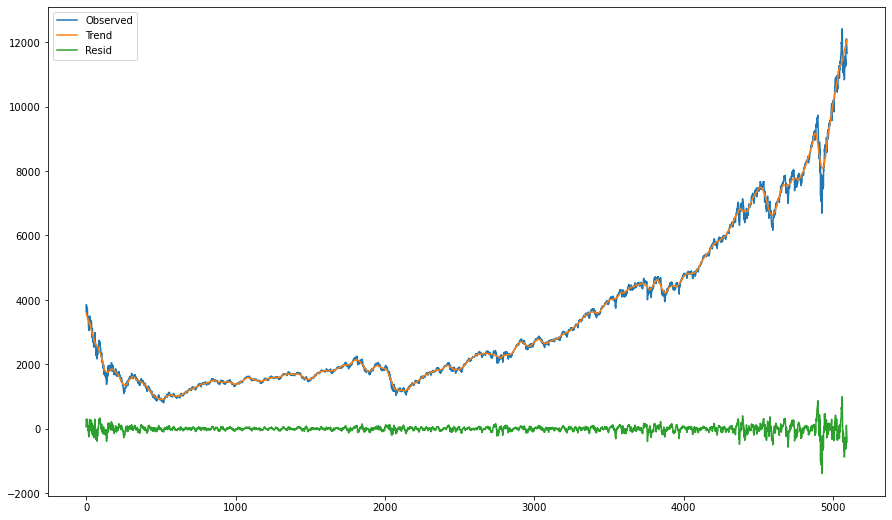

In [28]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

인베스팅 닷컴으로 확인해본 결과 코로나의 영향으로 나스닥은 2020년 3월 23일 최대 낙폭을 기록합니다. 또한 9월에 다시 조정기가 와서 하락하는 추세를 보이고 있습니다. 이러한 하락세를 보이는 데이터는 그룹4에 포함되어 있습니다.  
반면 그룹5는 코로나 이후 혹은 이전에 큰 상승세를 기록하던 데이터의 집합입니다.  
마찬가지로 그대로 내버려 두겠습니다. 

### DBSCAN 으로 이상치 찾기

In [29]:
from sklearn.cluster import DBSCAN
columns=df[['Open','High','Low','Close','Volume']]

model = DBSCAN(eps=0.3, min_samples=6)
predict = pd.DataFrame(model.fit_predict(columns))
predict.columns=['predict']

r = pd.concat([columns,predict],axis=1)

In [31]:
clustering = model.fit(norm_rdf)
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:924',
 'group:0-count:4153',
 'group:1-count:10',
 'group:2-count:7']

DBSCAN의 주변공간을 정의하는 데이터 벡터들로 부터의 반경 eps파라미터를 0.3으로 설정하고 최소 개수를 6으로 설정한결과 총 3개의 소수그룹을 생성해냈다.

##  Auto-Encoder를 이용한 이상치 탐색

In [140]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers

In [33]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [34]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [35]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


### 첫번째 모델: LSTM을 이용한 오토 인코더

In [118]:
input_ = Input(shape= (window_size, n_features))
x = LSTM(64, activation='tanh', return_sequences=True)(input_)
x = LSTM(16, activation='tanh', return_sequences=False)(x)
encoded = RepeatVector(window_size)(x)

d = LSTM(16, activation='tanh', return_sequences=True, dropout=0.5)(encoded)
d = LSTM(64, activation='tanh', return_sequences=False, dropout=0.5)(d)
decoded = Dense(n_features)(d)

lstm_model = Model(input_, decoded)

lstm_model.summary()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 10, 5)]           0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 10, 64)            17920     
_________________________________________________________________
lstm_37 (LSTM)               (None, 16)                5184      
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 10, 16)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 10, 16)            2112      
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_24 (Dense)             (None, 5)               

In [119]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

lstm_model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [120]:
lstm_hist = lstm_model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
157/159 [============================>.] - ETA: 0s - loss: 1.0773 - mae: 1.0773
Epoch 00001: val_loss improved from inf to 1.31325, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 2s 11ms/step - loss: 1.0671 - mae: 1.0671 - val_loss: 1.3132 - val_mae: 1.3132
Epoch 2/50
152/159 [===========================>..] - ETA: 0s - loss: 0.7144 - mae: 0.7144
Epoch 00002: val_loss improved from 1.31325 to 1.19066, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 5ms/step - loss: 0.6952 - mae: 0.6952 - val_loss: 1.1907 - val_mae: 1.1907
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 0.5068 - mae: 0.5068
Epoch 00003: val_loss improved from 1.19066 to 0.81745, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 5ms/step - loss: 0.5068 - mae: 0.5068 - val

Epoch 29/50
156/159 [============================>.] - ETA: 0s - loss: 0.3090 - mae: 0.3090
Epoch 00029: val_loss did not improve from 0.29671
159/159 [==============================] - 1s 5ms/step - loss: 0.3076 - mae: 0.3076 - val_loss: 0.5336 - val_mae: 0.5336
Epoch 30/50
158/159 [============================>.] - ETA: 0s - loss: 0.3516 - mae: 0.3516
Epoch 00030: val_loss did not improve from 0.29671
159/159 [==============================] - 1s 5ms/step - loss: 0.3505 - mae: 0.3505 - val_loss: 0.3988 - val_mae: 0.3988
Epoch 31/50
154/159 [============================>.] - ETA: 0s - loss: 0.2810 - mae: 0.2810
Epoch 00031: val_loss improved from 0.29671 to 0.28102, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 1s 6ms/step - loss: 0.2768 - mae: 0.2768 - val_loss: 0.2810 - val_mae: 0.2810
Epoch 32/50
152/159 [===========================>..] - ETA: 0s - loss: 0.2672 - mae: 0.2672
Epoch 00032: val_loss improved fro

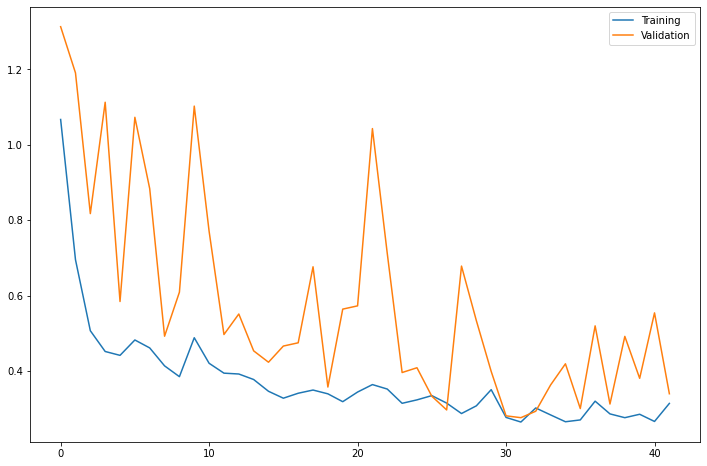

In [135]:
fig = plt.figure(figsize=(12,8))
plt.plot(lstm_hist.history['loss'], label='Training')
plt.plot(lstm_hist.history['val_loss'], label='Validation')
plt.legend()

### 두 번째 모델: 1D Convolutional 오토 인코더

In [109]:
input_ = Input(shape= (window_size, n_features))
x = Conv1D(128, 2, activation='relu', padding='same')(input_)
x = MaxPooling1D(2, padding= 'same')(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 2, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding= 'same')(x)
x = Dropout(0.2)(x)
x = Conv1D(32, 2, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding= 'same')(x)

d = Conv1D(32, 1, activation='relu', padding='same')(encoded)
d = UpSampling1D(2)(d)
d = Dropout(0.2)(d)
d = Conv1D(64, 1, activation='relu', padding='same')(encoded)
d = UpSampling1D(2)(d)
d = Dropout(0.2)(d)
d = Conv1D(128, 2, activation='relu')(d)
d = UpSampling1D(2)(d)
d = Flatten()(d)
d = Dense(100)(d)
d = Dropout(0.5)(d)
decoded = Dense(n_features)(d)
conv_model = Model(input_, decoded)

conv_model.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 10, 5)]           0         
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 10, 128)           1408      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 5, 64)             16448     
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 64)           

In [110]:
conv_model.compile(loss='mae', optimizer=Adam(learning_rate=0.001),metrics=["mae"])

conv_hist = conv_model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
141/159 [=========================>....] - ETA: 0s - loss: 0.8387 - mae: 0.8387
Epoch 00001: val_loss did not improve from 0.25341
159/159 [==============================] - 1s 4ms/step - loss: 0.7962 - mae: 0.7962 - val_loss: 1.0778 - val_mae: 1.0778
Epoch 2/50
147/159 [==========================>...] - ETA: 0s - loss: 0.5618 - mae: 0.5618
Epoch 00002: val_loss did not improve from 0.25341
159/159 [==============================] - 0s 3ms/step - loss: 0.5536 - mae: 0.5536 - val_loss: 1.7049 - val_mae: 1.7049
Epoch 3/50
144/159 [==========================>...] - ETA: 0s - loss: 0.5953 - mae: 0.5953
Epoch 00003: val_loss did not improve from 0.25341
159/159 [==============================] - 0s 3ms/step - loss: 0.6046 - mae: 0.6046 - val_loss: 2.4236 - val_mae: 2.4236
Epoch 4/50
151/159 [===========================>..] - ETA: 0s - loss: 0.5584 - mae: 0.5584
Epoch 00004: val_loss did not improve from 0.25341
159/159 [==============================] - 0s 3ms/step - loss: 0.5552

In [169]:
model.load_weights(checkpoint_path)

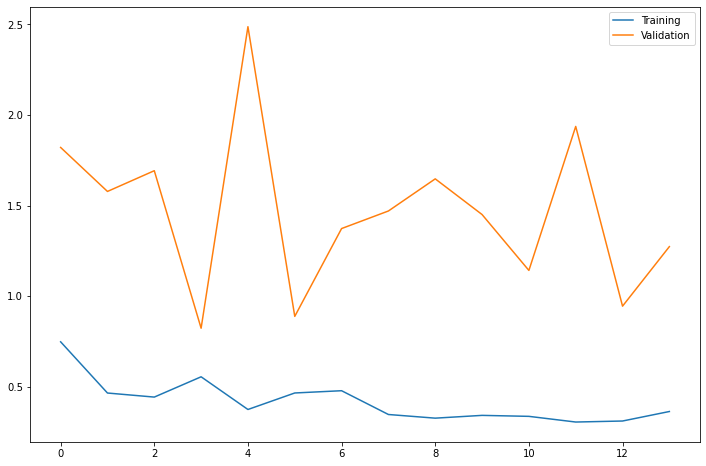

In [108]:
fig = plt.figure(figsize=(12,8))
plt.plot(conv_hist.history['loss'], label='Training')
plt.plot(conv_hist.history['val_loss'], label='Validation')
plt.legend()

### 세 번째 모델: Dense 오토 인코더

In [145]:
input_ = Input(shape= (window_size, n_features))
x = Dense(128, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)

d = Dense(16, activation='relu')(x)
d = Dense(32, activation='relu')(d)
d = Dense(128, activation='relu')(d)
d = Flatten()(d)
d = Dropout(0.5)(d)
decoded = Dense(n_features)(d)
dense_model = Model(input_, decoded)

dense_model.summary()

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 10, 5)]           0         
_________________________________________________________________
dense_68 (Dense)             (None, 10, 128)           768       
_________________________________________________________________
dense_69 (Dense)             (None, 10, 32)            4128      
_________________________________________________________________
dense_70 (Dense)             (None, 10, 16)            528       
_________________________________________________________________
dense_71 (Dense)             (None, 10, 16)            272       
_________________________________________________________________
dense_72 (Dense)             (None, 10, 32)            544       
_________________________________________________________________
dense_73 (Dense)             (None, 10, 128)         

In [146]:
dense_model.compile(loss='mae', optimizer=Adam(learning_rate=0.001),metrics=["mae"])

dense_hist = dense_model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 0.7868 - mae: 0.7537
Epoch 00001: val_loss did not improve from 0.27615
159/159 [==============================] - 1s 4ms/step - loss: 0.7868 - mae: 0.7537 - val_loss: 0.4405 - val_mae: 0.3634
Epoch 2/50
144/159 [==========================>...] - ETA: 0s - loss: 0.3930 - mae: 0.3637
Epoch 00002: val_loss did not improve from 0.27615
159/159 [==============================] - 0s 3ms/step - loss: 0.3926 - mae: 0.3630 - val_loss: 0.5143 - val_mae: 0.4442
Epoch 3/50
134/159 [========================>.....] - ETA: 0s - loss: 0.3605 - mae: 0.3347
Epoch 00003: val_loss did not improve from 0.27615
159/159 [==============================] - 0s 3ms/step - loss: 0.3719 - mae: 0.3452 - val_loss: 0.6838 - val_mae: 0.6209
Epoch 4/50
143/159 [=========================>....] - ETA: 0s - loss: 0.4238 - mae: 0.4001
Epoch 00004: val_loss did not improve from 0.27615
159/159 [==============================] - 1s 3ms/step - loss: 0.4256

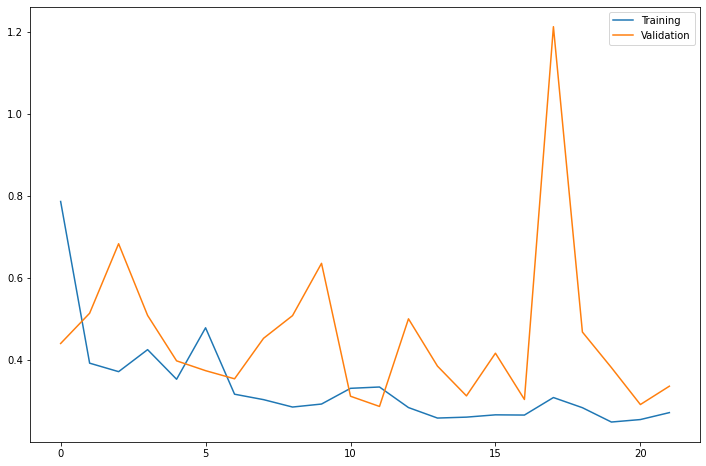

In [147]:
fig = plt.figure(figsize=(12,8))
plt.plot(dense_hist.history['loss'], label='Training')
plt.plot(dense_hist.history['val_loss'], label='Validation')
plt.legend()

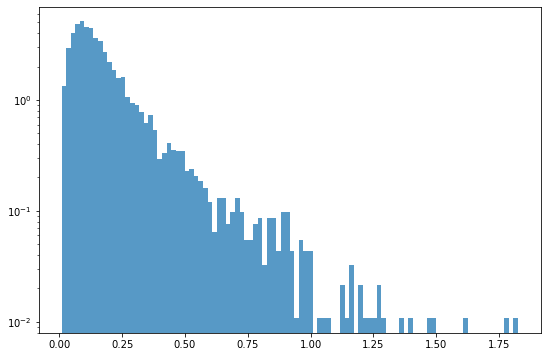

In [148]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = dense_model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

threshold를 1.3으로 두고 그 이상의 값은 이상치라고 가정하겠습니다.

In [154]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4580,2018-12-21,6307.50,6317.750000,6242.000000,6257.250000,6257.250000,862689.0,1.479768
4894,2020-02-27,8811.50,8878.500000,8334.250000,8382.750000,8382.750000,1580041.0,1.480867
4920,2020-03-29,7395.75,7507.250000,7367.250000,7489.250000,7489.250000,1256384.0,1.782725
4930,2020-04-12,8296.00,8327.500000,8073.250000,8115.750000,8115.750000,1224003.0,1.825618
5006,2020-07-12,10848.25,10909.500000,10847.750000,10886.750000,10886.750000,884254.0,1.392482
5053,2020-09-04,11745.00,11843.000000,11142.000000,11548.799805,11548.799805,1202274.0,1.616680
5062,2020-09-18,11082.00,11179.200195,11037.200195,11144.799805,11144.799805,800279.0,1.354318


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


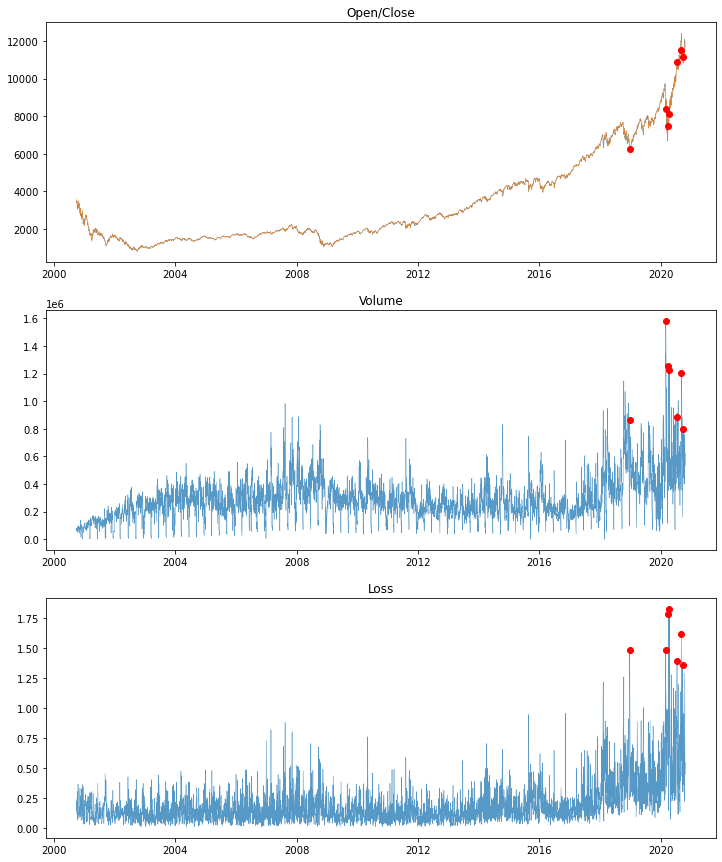

In [155]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

이상치들을 붉은 점으로 나타내고 그래프로 그려본 결과 최대 낙폭지점과, 최대 상승 지점에서 빨간 점이 보입니다. 이는 outlier라고 하기 보다 특이치라고 보는게 적당한 것 같습니다.

## Report

이번 실습에서는 기본 통계분석으로 이상치 찾기, Unsupervised Clustering 방식으로 이상치 찾기, Auto-Encoder를 활용해 이상치 찾기로 총 3가지 방법을 활용해봤습니다. 
- 기본 통계분석으로 이상치 찾기는 Time series decompose를 하여 resid 성분을 뽑아내서 분석하는 방법입니다. resid 성분은 정규분포의 형태를 띄고 있습니다. 이 분포에서 일정 이상 벗어나는 데이터를 이상치로 구분하기 때문에 직관적으로 이해가 잘 되는 것 같습니다. 
- Unsupervised Clustering은 군집을 형성하고 소수의 집합을 이상치로 가정하는 방법이었습니다. 이 방식 또한 Time series decomposition 분석이 추가되는 단점이 있습니다. 하지만 적은 샘플로도 이상치를 분리할 수 있다는 장점이 있습니다. 
- Auto-Encoder 모델은 딥러닝 모델을 활용하여 특징을 검출하고 이상치를 찾는 방법입니다. 딥러닝을 활용한 방식이기 때문에 기존의 decomposition을 거치지 않아도 되는 장점이 있습니다. 또한 다양한 모델을 사용하거나 변형시켜서 더 나은 성능을 낼 수 있습니다. 

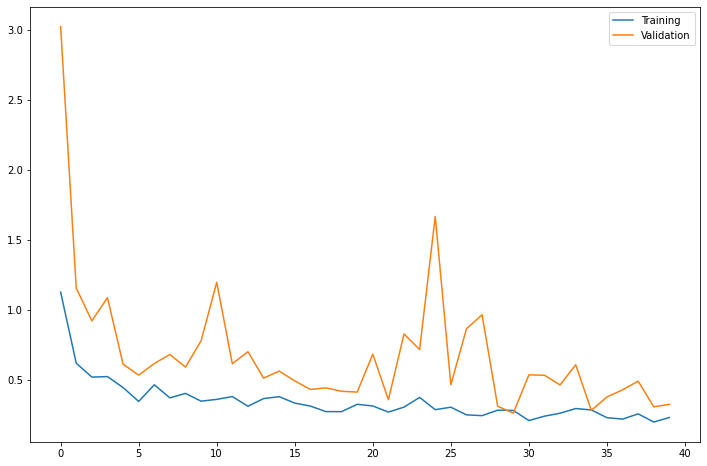

In [175]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

기본 auto-encoder 모델에서 activation을 tanh로 변경한 결과입니다. 안정적으로 수렴하는 모습을 볼 수 있습니다.

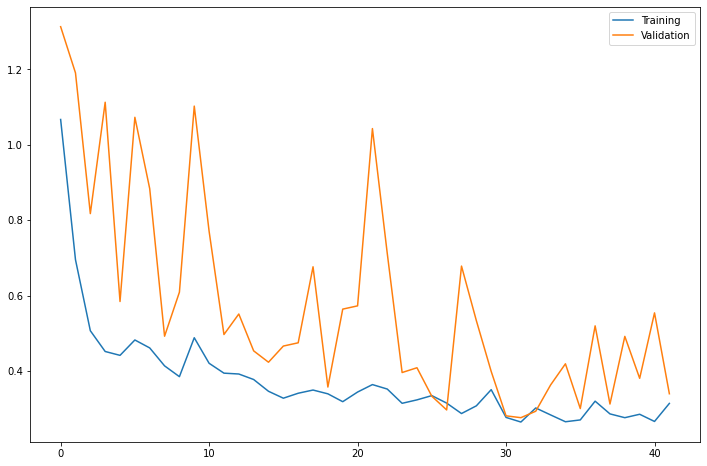

In [139]:
fig = plt.figure(figsize=(12,8))
plt.plot(lstm_hist.history['loss'], label='Training')
plt.plot(lstm_hist.history['val_loss'], label='Validation')
plt.legend()

decoder 부분에 dropout을 적용하였더니 더 괜찮은 성능을 보여주고 있습니다. 

다양한 모델로 실험한 결과 LSTM 모델이 가장 안정적이고 성능이 좋았습니다. 